# Hierarchical Models

This chapter continues from where the last one ended and explores more varieties of hierarchical models. Here I've explored npxG/Shot as the means to modify the priors using regression. There is definitely a strong correlation between the two which is not unsurprising to me at all. What's not entirely clear to me is whether this should be used as an input to modify the priors. I could probably argue for, but would wait for more expert opinions.

In [16]:
%load_ext autoreload
%autoreload 2

import scipy.special as special
from scipy.stats import beta,binom,chi2_contingency,gaussian_kde,rv_continuous,norm,rv_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np
import numpy.typing as npt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression

df = pd.read_csv('fbrefshootingdata.csv', encoding='utf-8-sig')
df = df[(df.npG >= 1) & (df.Shots >= 50)].reset_index(drop=True)
df['Conv'] = df['npG']/df['Shots']
bf = beta.fit(df['Conv'], floc=0, fscale=1)
df['Eb_Conv'] = (df['npG']+bf[0])/(df['Shots']+bf[0]+bf[1])
df['a'] = df['npG'] + bf[0]
df['b'] = df['Shots'] + bf[1] - df['npG']
df.rename(columns = {'90s':'Nineties'},inplace=True)
df['npxG/Shot'] = df['npxG']/df['Shots']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
df.head()

,Player,Nineties,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv,a,b,npxG/Shot
0,Aaron Connolly (2000),24.5,5.0,63.0,0.0,7.2,5.0,2000.0,21.0,0.079365,0.085783,8.648493,92.169808,0.114286
1,Aaron Cresswell (1989),133.0,5.0,78.0,0.0,3.9,5.0,1989.0,32.0,0.064103,0.074673,8.648493,107.169808,0.050000
2,Aaron Leya Iseka (1997),35.8,10.0,73.0,3.0,10.0,7.0,1997.0,24.0,0.095890,0.096090,10.648493,100.169808,0.136986
3,Aaron Mooy (1990),83.2,9.0,100.0,2.0,5.5,7.0,1990.0,31.0,0.070000,0.077265,10.648493,127.169808,0.055000
4,Aaron Ramsey (1990),60.2,16.0,139.0,0.0,17.1,16.0,1990.0,31.0,0.115108,0.111123,19.648493,157.169808,0.123022


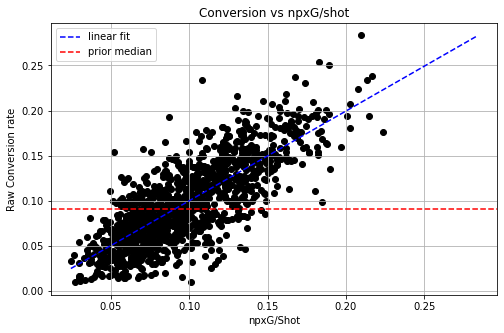

In [24]:
def plot_fit(qty1,qty2,xlabel,ylabel,title,ax):
    x = (df[qty1].values.reshape(-1,1))
    y = (df[qty2].values)
    model = LinearRegression().fit(x,y)
    intc, slope = model.intercept_, model.coef_
    X = np.linspace(df[qty1].min(), df[qty2].max(), 100)
    Y = slope*(X) + intc
    ax.scatter(df[qty1], df[qty2], color='k')
    ax.plot(X, Y, color = 'b', ls='--',zorder=3, label='linear fit')
    ax.axhline(df.Conv.median(), color='r', ls = '--', zorder=2, label = 'prior median')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid();
    ax.legend();
fig, ax = plt.subplots(figsize=(8,5))
plot_fit('npxG/Shot', 'Conv', 'npxG/Shot', 'Raw Conversion rate','Conversion vs npxG/shot',ax)

In [21]:
def BBLL1(params,Y,X):
    N = df.Shots.values
    mu0, mu1, phi = params
    mu = special.expit(mu0 + mu1*X) 
    a = mu*phi
    b = (1-mu)*phi
    t1 = special.loggamma(N+1+1e-15) - special.loggamma(Y+1+1e-15) - special.loggamma(N-Y+1+1e-15)  
    t2 = special.loggamma(Y+a+1e-15) + special.loggamma(N-Y+b+1e-15) - special.loggamma(N+a+b+1e-15)
    t3 = special.loggamma(a+b+1e-15) - special.loggamma(a+1e-15) - special.loggamma(b+1e-15)
    total = -np.sum(t1 + t2 + t3)
    return total
res = minimize(BBLL1, x0=[0,0,100], args=(df.npG.values,df['npxG/Shot'].values),
               bounds=[(None,None),(None,None),(0,None)])
mu0, mu1 = res.x[:-1]
sigma0 = 1/res.x[-1]

df['new_a'] = special.expit(mu0 + mu1*df['npxG/Shot'])/sigma0 + df['npG']
df['new_b'] = (1 - special.expit(mu0 + mu1*df['npxG/Shot']))/sigma0 + df['Shots'] - df['npG']
df['new_Conv'] = df['new_a']/(df['new_a'] + df['new_b'])
df.head()

,Player,Nineties,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv,a,b,npxG/Shot,new_a,new_b,new_Conv
0,Aaron Connolly (2000),24.5,5.0,63.0,0.0,7.2,5.0,2000.0,21.0,0.079365,0.085783,8.648493,92.169808,0.114286,90.839154,747.838773,0.108312
1,Aaron Cresswell (1989),133.0,5.0,78.0,0.0,3.9,5.0,1989.0,32.0,0.064103,0.074673,8.648493,107.169808,0.050000,51.393793,802.284135,0.060203
2,Aaron Leya Iseka (1997),35.8,10.0,73.0,3.0,10.0,7.0,1997.0,24.0,0.095890,0.096090,10.648493,100.169808,0.136986,112.660831,736.017096,0.132749
3,Aaron Mooy (1990),83.2,9.0,100.0,2.0,5.5,7.0,1990.0,31.0,0.070000,0.077265,10.648493,127.169808,0.055000,55.722901,819.955027,0.063634
4,Aaron Ramsey (1990),60.2,16.0,139.0,0.0,17.1,16.0,1990.0,31.0,0.115108,0.111123,19.648493,157.169808,0.123022,109.050149,805.627779,0.119222


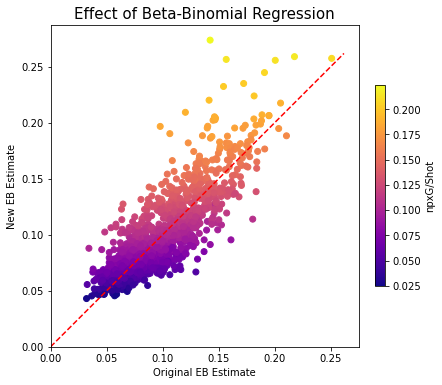

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.scatter(df.Eb_Conv, df.new_Conv, c=df['npxG/Shot'], cmap=mpl.cm.plasma);
ax.plot(np.linspace(0, ax.get_xlim()[1],100), np.linspace(0, ax.get_xlim()[1],100), color='red', linestyle='--')
ax.set_aspect('equal')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Original EB Estimate')
ax.set_ylabel('New EB Estimate')
fig.colorbar(im, ax=ax, fraction=.03).set_label('npxG/Shot');
ax.set_title('Effect of Beta-Binomial Regression', fontsize = 15);

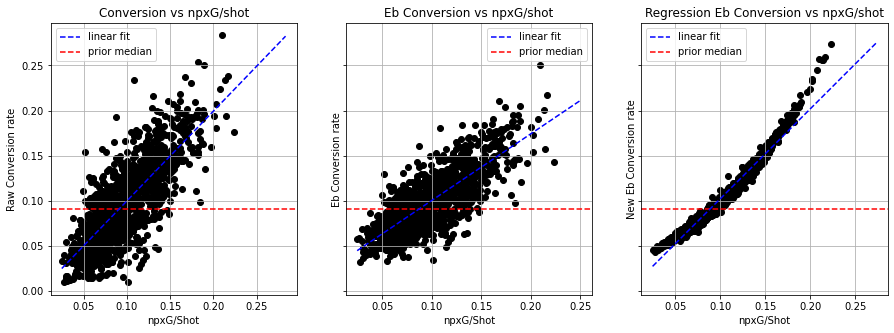

In [28]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3,sharey=True)
plot_fit('npxG/Shot', 'Conv', 'npxG/Shot', 'Raw Conversion rate','Conversion vs npxG/shot',ax[0])
plot_fit('npxG/Shot', 'Eb_Conv', 'npxG/Shot', 'Eb Conversion rate','Eb Conversion vs npxG/shot',ax[1])
plot_fit('npxG/Shot', 'new_Conv', 'npxG/Shot', 'New Eb Conversion rate','Regression Eb Conversion vs npxG/shot',ax[2])